## API

- `bf.add(x)`: adds x in the data structure
- `x in bf`: tests if x is in the data structure.

## Why not use Set or Dict?
- Bloom filters are more space efficients. They take memory lesser than the keys themselves.

## Cons
- can't store associated data. 
- does not support deletions.
- It is probabilistic data structure. That means, `x in bf` might have false positives. There are no false negatives. 

## Applications
- Spell checkers: (40 years ago) Add the dictionary into the filter. If the word is in the bloom filter, it is higly likely tobe correctly spelled word.
- list of forbidden password. E.g., too common password.
- Modern applications: Routers, a lot of packets incoming. 

## How does it work?
- we have a data set `S` of size `|S|`.
- have an array of `n` bits.
- $b = \frac{n}{|S|}$ bits per element.
- have `k` hash functions.

In [33]:
import numpy as np

class BitArray:
    def __init__(self, n):
        self.array = np.zeros((n >> 3) + 1, dtype=np.uint8)
    
    def set(self, i):
        i, j = divmod(i, 8)
        self.array[i] = self.array[i] | (1 << j)
    
    def get(self, i):
        i, j = divmod(i, 8)
        return bool(self.array[i] & (1 << j))

In [34]:
import xxhash

def get_hashes_for_str(x, k):
    # Only h1 and h2 are computed afresh. Remaining hash 
    # functions are just linear combinations of h1 and h2.
    
    assert k > 1
    
    h1 = xxhash.xxh64_intdigest(x, seed=42)
    h2 = xxhash.xxh64_intdigest(x, seed=84)
    hashes = [h1, h2]
    
    for i in range(2, k):
        hashes.append(h1 + i*h2)
    return hashes

class BloomFilter:
    def __init__(self, n, k):
        self.array = BitArray(n)
        self.k = k
        self.n = n
        
    def add(self, key):
        for h in get_hashes_for_str(key, self.k):
            self.array.set(h % self.n)
            
    def __contains__(self, key):
        for h in get_hashes_for_str(key, self.k):
            if not self.array.get(h % self.n):
                return False
        return True

In [8]:
text = "correct incorrect".split()
bm = BloomFilter(10, 5)

for word in text:
    bm.add(word)

In [9]:
for word in text:
    assert word in bm

In [10]:
assert "notcorrect" not in bm

## Analysis

Trade off between erro rate and space required. Data structre will be useful when there is a sweetspot on the tradeoff curve.

Assumption: The hash functions are independent and they distribute the data uniformly. 

Out of n bits, focus on a particular bit. What is the probability that it has been set?

It is probability of 1 minus it hasn't been set by any of the `|S|` elements, for any of the `k` hash functions. 

$p = 1 - (1 - \frac{1}{n})^{k|S|}$.

As can be seen by the plot below, $1+x$ can be approximated by $e^x$ when x is close to zero. In all cases, $e^x$ is an overestimate of $1+x$.

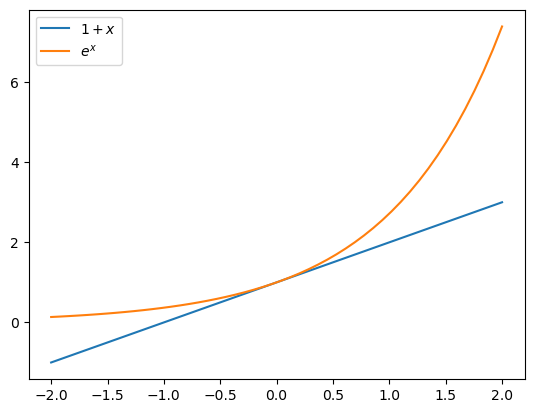

In [48]:
import matplotlib.pyplot as plt
x = np.linspace(-2, 2)
plt.plot(x, 1+x, label="$1 +x$")
plt.plot(x, np.exp(x), label="$e^x$")
plt.legend();

Thus, $p \approx 1 - e^{\frac{-k|S|}{n}} = 1 - e^{\frac{-k}{b}}$. Remember, b is the bits per element.

As $b \to \inf$, $p \to 0$.

Thus, the probability of false positive is $\epsilon = (1-e^{\frac{-k}{b}})^k$.

## How to set K?

Set K optimally. Fix the b, then set k to minimize the error. 
Using calculus, $k \approx (ln 2) b$.

When we plug this back into the p, we get $\epsilon \approx (\frac{1}{2})^\left((ln 2) b\right)$. Notice that error rate is exponential in b.

Using little bit of algebra we can get $b \approx 1.44 log_2{\frac{1}{\epsilon}}$. (Hint: $1.44 \approx \frac{1}{ln2}$.)

## How does theory differ from practice

In [28]:
import string
import random
import numpy as np

letters = np.array(list(string.ascii_letters + string.digits))

def random_str():
    return ''.join(np.random.choice(letters, np.random.randint(4, 9)))

Generate 1M keys, and insert them in the bloom filter. Just for sanity check, I will test if there is no false negative. Then I will generate keys at random, check if it is in actually there, and how often does bloom filter give false positive. Recall that error rate as a function of b = n/10M is $\approx (\frac{1}{2})^{(ln 2) b}$.

In [38]:
actually_there = set()
set_size = int(1e6)
while len(actually_there) != set_size:
    actually_there.add(random_str())

In [42]:
from tqdm.auto import tqdm

In [59]:
bs = [4, 8, 12, 16]
fpve_rate = []
theory = []

for b in bs:
    theory.append(.5**(np.log(2)*b))
    bm = BloomFilter(b*set_size, k=int(np.log(2)*b))
    for key in actually_there:
        bm.add(key)
    
    for key in actually_there:
        assert key in bm
        
    fpve, total = 0, 0
    while total < 10_000:
        key = random_str()
        if key in actually_there: continue
        if key in bm:
            fpve += 1
        total += 1
    
    fpve_rate.append(fpve/total)

Text(0.5, 0, 'bits per element')

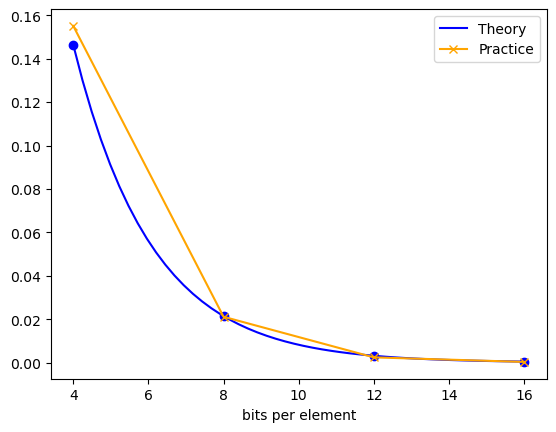

In [57]:
bs_lin = np.linspace(bs[0], bs[-1])
plt.plot(bs_lin, .5**(np.log(2)*bs_lin), label="Theory", c='b') 
plt.plot(bs, theory, 'o', c='b')
plt.plot(bs, fpve_rate, '-x', label="Practice", c='orange')
plt.legend();
plt.xlabel("bits per element");
plt.ylabel("false positive rate");


at b=12, false positive rate is already less than 0.5%.